In [3]:
from scipy.stats import ncx2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Preliminaries: Assign the basic parameters
# Time period for the simulation (1 year)
T = 1.0

# Number of time steps (discrete intervals for simulation)
nsteps = 250

# Time step size (dt) is the total time divided by the number of steps
dt = T / nsteps

# Number of realizations (simulated paths of the process)
nsimul = 5

# Create an empty array to store the realizations (nsteps+1 rows, nsimul columns)
x = np.empty((nsteps + 1, nsimul))

In [5]:
# Assign the parameters of the CEV (Constant Elasticity of Variance) process
# Initial spot price (S0), drift (mu), volatility coefficient (sigma), and elasticity of variance (b)
S0 = 1      # Spot forward price
mu = 0.1    # Drift term
sigma = 0.2 # Volatility coefficient
b = 1.6     # Elasticity of variance (controls how variance depends on price level)

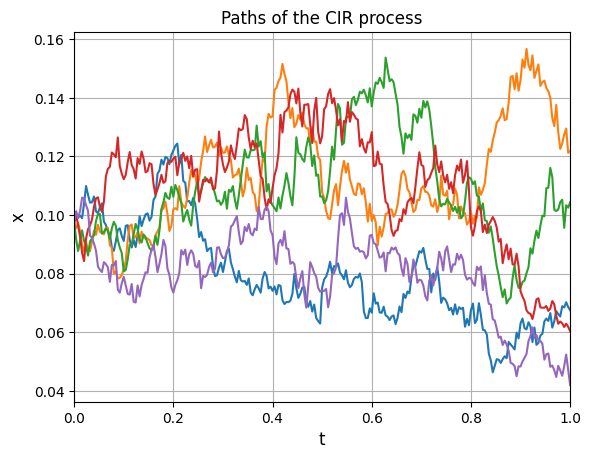

In [6]:
# The base: CIR (Cox-Ingersoll-Ross) process
# Convert the CEV parameters into the corresponding CIR process parameters
kappa = 2 * mu * b    # Mean-reversion speed in the CIR process
eta = -sigma * np.sign(b)  # Volatility term (adjusted by the sign of b)
theta = (eta ** 2 * (2 * b + 1)) / (4 * kappa * b)  # Long-term mean (theta) in CIR process

# Degrees of freedom for the non-central chi-squared distribution (ncx2)
df = 4 * kappa * theta / (eta ** 2)

# Rescaling factor for the non-central chi-squared distribution
ct = (eta ** 2 * (1 - np.exp(-kappa * dt))) / (4 * kappa)

# Initialize the starting value for the CIR process (transformed from the initial S0 value)
x[0, :] = (S0 ** (-2 * b) / (4 * b ** 2)) * np.ones((1, nsimul))

# Generate paths of the CIR process
for j in range(1, nsteps + 1):
    # Non-centrality parameter for the non-central chi-squared distribution
    ncp = x[j-1, :] * np.exp(-kappa * dt) / ct
    # Simulate the next step in the CIR process using the ncx2 distribution
    x[j, :] = ct * ncx2.rvs(df, ncp, size=nsimul)

# Plot the CIR process paths
t = np.linspace(0.0, nsteps * dt, nsteps + 1)  # Generate time points
t = t.reshape(nsteps + 1, 1)  # Reshape for plotting

# Plot each realization (simulated path) of the CIR process
for k in range(nsimul):
    plt.plot(t, x[:, k])
plt.xlim([0, T])
plt.xlabel('t', fontsize=12)
plt.ylabel('x', fontsize=12)
plt.title('Paths of the CIR process')
plt.grid(True)
plt.show()

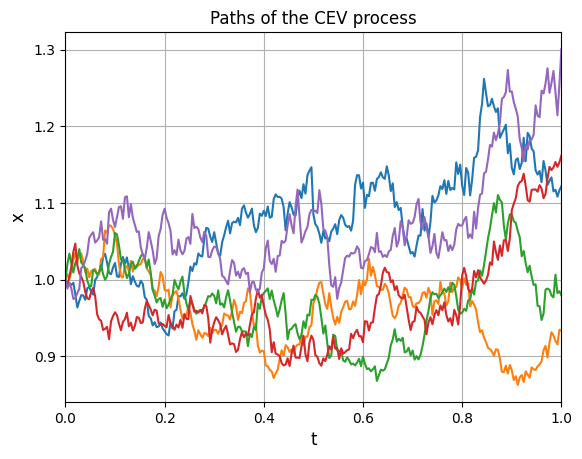

In [7]:
# The CEV process
# Convert the CIR process back to the CEV process (reverse the transformation)
S = (4 * b ** 2 * x) ** (-1 / (2 * b))

# Plot the CEV process paths
for k in range(nsimul):
    plt.plot(t, S[:, k])
plt.xlim([0, T])
plt.xlabel('t', fontsize=12)
plt.ylabel('x', fontsize=12)
plt.title('Paths of the CEV process')
plt.grid(True)
plt.show()

Calculate the mean of the CIR process via basic Monte Carlo simulation

In [9]:
#Simulate the CIR process using Monte Carlo
def CIR(v0, kappa, eta, theta, nsteps, nsim):
    df = 4 * kappa * theta / (eta ** 2)  # Degrees of freedom of the ncx2 distribution
    ct = (eta ** 2 * (1 - np.exp(-kappa * dt))) / (4 * kappa)  # Rescaling factor
    v = np.empty((nsteps + 1, nsim))  # Initialize the array to store the paths
    v[0, :] = v0 * np.ones((1, nsimul))  # Set the initial value
    
    for j in range(1, nsteps + 1):
        ncp = v[j-1, :] * np.exp(-kappa * dt) / ct  # Non-centrality parameter
        v[j, :] = ct * ncx2.rvs(df, ncp, size=nsim)  # Generate the next step
    return v

# Parameters for Monte Carlo simulation
nsimul = 10**6  # Large number of simulations for more accurate results
x0 = S0 ** (-2 * b) / (4 * b ** 2)  # Initial value

import time
start_time = time.time()  # Track the start time of the simulation

# Run the Monte Carlo simulation
x = CIR(x0, kappa, eta, theta, nsteps, nsimul)

# Print the time taken for the simulation
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.131764888763428 seconds ---


In [10]:
# Calculate the mean of the simulated CIR process at each time step
Exp_CIR = np.mean(x, axis=1)

# Display the final expected value of the CIR process
print(Exp_CIR[nsteps])  

0.09339323420745264


In [12]:
# Exact expected value of the CIR process using the known formula
Exp_CIR_exact = theta - (theta - x0) * np.exp(-kappa * T)
print(Exp_CIR_exact)  

0.09337732870427641
